In [68]:
import os
from collections import defaultdict
from functools import partial

import numpy as np
import pyro
import pyro.distributions as dist
import scipy.stats
import torch
import torch.distributions.constraints as constraints
from matplotlib import pyplot
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.poutine import block, replay, trace

/opt/homebrew/Caskroom/miniforge/base/envs/ubvi/lib/python3.9/site-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


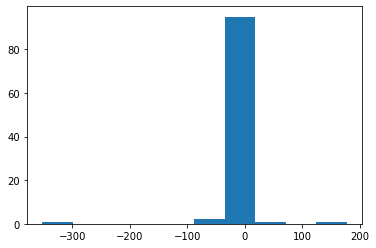

In [69]:
x = dist.Cauchy(0, 1).sample_n(100)
pyplot.hist(x.numpy())
pyplot.show()

In [70]:
# def model(data):
#     prior_loc = torch.tensor([0.])
#     prior_scale = torch.tensor([5.])
#     z = pyro.sample('z', dist.Normal(prior_loc, prior_scale))
#     scale = torch.tensor([0.1])

#     with pyro.plate('data', len(data)):
#         pyro.sample('x', dist.Normal(z*z, scale), obs=data)

def model(data):
    prior_loc = torch.tensor([0.])
    prior_scale = torch.tensor([1])
    z = pyro.sample('z', dist.Cauchy(prior_loc, prior_scale))
    scale = torch.tensor([0.1])

    with pyro.plate('data', len(data)):
        pyro.sample('x', dist.Cauchy(prior_loc, prior_scale), obs=data)

def guide(data, index):
    scale_q = pyro.param('scale_{}'.format(index), torch.tensor([1.0]), constraints.positive)
    loc_q = pyro.param('loc_{}'.format(index), torch.tensor([0.0]))
    pyro.sample("z", dist.Normal(loc_q, scale_q))

def relbo(model, guide, *args, **kwargs):
    approximation = kwargs.pop('approximation')

    # We first compute the elbo, but record a guide trace for use below.
    traced_guide = trace(guide)
    elbo = pyro.infer.Trace_ELBO(max_plate_nesting=1)
    loss_fn = elbo.differentiable_loss(model, traced_guide, *args, **kwargs)

    # We do not want to update parameters of previously fitted components
    # and thus block all parameters in the approximation apart from z.
    guide_trace = traced_guide.trace
    replayed_approximation = trace(replay(block(approximation, expose=['z']), guide_trace))
    approximation_trace = replayed_approximation.get_trace(*args, **kwargs)

    relbo = -loss_fn - approximation_trace.log_prob_sum()

    # By convention, the negative (R)ELBO is returned.
    return -relbo

def approximation(data, components, weights):
    assignment = pyro.sample('assignment', dist.Categorical(weights))
    result = components[assignment](data)
    return result

In [74]:
initial_approximation = partial(guide, index=0)
components = [initial_approximation]
weights = torch.tensor([1.])
wrapped_approximation = partial(approximation, components=components, weights=weights)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# Sample observations from a Normal distribution with loc 4 and scale 0.1
n = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([10.]))
n = torch.distributions.Uniform(torch.tensor([-10.]), torch.tensor([10.]))
data = n.sample((100,))

#T=2
smoke_test = ('CI' in os.environ)
n_steps = 5 if smoke_test else 12000
pyro.set_rng_seed(2)
n_iterations = 10
locs = [0]
scales = [0]
for t in range(1, n_iterations + 1):

    # Create guide that only takes data as argument
    wrapped_guide = partial(guide, index=t)
    losses = []

    adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
    optimizer = Adam(adam_params)

    # Pass our custom RELBO to SVI as the loss function.
    svi = SVI(model, wrapped_guide, optimizer, loss=relbo)
    for step in range(n_steps):
        # Pass the existing approximation to SVI.
        loss = svi.step(data, approximation=wrapped_approximation)
        losses.append(loss)

        if step % 100 == 0:
            print('.', end=' ')

    # Update the list of approximation components.
    components.append(wrapped_guide)

    # Set new mixture weight.
    new_weight = 2 / (t + 1)

    # In this specific case, we set the mixture weight of the second component to 0.5.
    if t == 2:
        new_weight = 0.5
    weights = weights * (1-new_weight)
    weights = torch.cat((weights, torch.tensor([new_weight])))

    # Update the approximation
    wrapped_approximation = partial(approximation, components=components, weights=weights)

    print('Parameters of component {}:'.format(t))
    scale = pyro.param("scale_{}".format(t)).item()
    scales.append(scale)
    loc = pyro.param("loc_{}".format(t)).item()
    locs.append(loc)
    print('loc = {}'.format(loc))
    print('scale = {}'.format(scale))

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Parameters of component 1:
loc = 2.5843803882598877
scale = 10246337536.0
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Parameters of component 2:
loc = -0.10843228548765182
scale = 1.5695017576217651
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Parameters of component 3:
loc = -1.3442174196243286
scale = 21315483648.0
. . . . . . . . . . . . . . . . . . . . . . . . . 

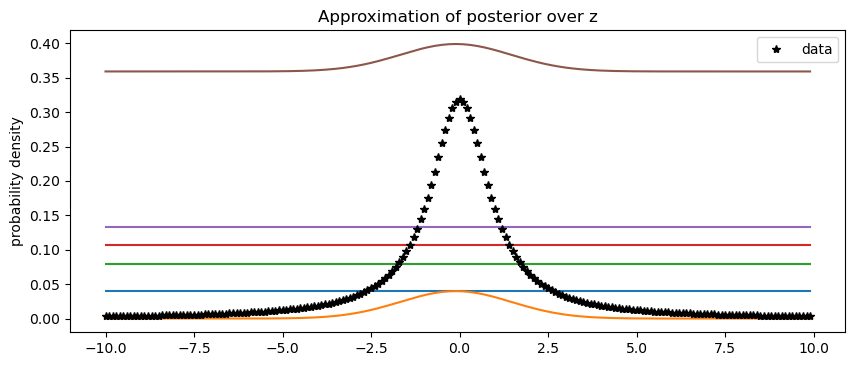

In [73]:
# Plot the resulting approximation
X = np.arange(-10, 10, .1)
pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
total_approximation = np.zeros(X.shape)
for i in range(1, n_iterations + 1):
    Y = weights[i].item() * scipy.stats.norm.pdf((X - locs[i]) / scales[i])
    pyplot.plot(X, Y)
    total_approximation += Y

pyplot.plot(X, total_approximation)
# pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*', label='data')
pyplot.plot(X, scipy.stats.cauchy.pdf(X), 'k*', label='data')
pyplot.legend()
pyplot.title('Approximation of posterior over z')
pyplot.ylabel('probability density')
pyplot.show()